# [hotsline](https://github.com/AntoineGrimaldi/hotsline) algorithm to replicate results from [this paper](https://www.techrxiv.org/articles/preprint/A_robust_event-driven_approach_to_always-on_object_recognition/18003077/1)
## Load events of the NMNIST dataset with [Tonic](https://tonic.readthedocs.io/en/latest/index.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, get_sliced_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy, make_and_display_ts
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/'

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [3]:
kfold_test = 5
kfold_clust = 10
ts_batch_size = int(3e4)

dataset_name = 'gesture'
slicing_time_window = 1e6

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=type_transform)
loader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_clust)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_test)
num_sample_train = len(trainloader)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=True, kfold=kfold_test)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

../../Data/DVSGesture/metadata/gesture_1000_True_True
Read metadata from disk.
../../Data/DVSGesture/metadata/gesture_1000_True_True
Read metadata from disk.
../../Data/DVSGesture/metadata/gesture_1000_True_False
Read metadata from disk.
number of samples in the training set: 209
number of samples in the testing set: 44


In [4]:
name = 'homeohots'
homeo = True
timestr = '2023-01-04'
device = 'cuda'

R_first = [4]
N_layers = [2]
n_first = [16]
tau_first = [1e3, 2e3, 3e3, 4e3, 5e3, 6e3]

scores, parameters = [], []

for lay in N_layers:
    for R in R_first:
        for tau in tau_first:
            for N_neuron in n_first:
                Rz = [R*2**Nl for Nl in range(lay)]
                N_neuronz = [N_neuron*2**Nl for Nl in range(lay)]
                N_neuronz = [64, 16]
                N_pola = N_neuronz.copy()
                N_pola.insert(0,2)
                tauz = [tau*N_pola[Nl] for Nl in range(lay)]
                print(f'For tau equal: {tau}')
                
                hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)
                initial_name = hots.name
                filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
                path = record_path+'networks/'+hots.name+'.pkl'
                if not os.path.exists(path):
                    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold, ts_batch_size = ts_batch_size, device = device)
                #hots.plotlayers()
                
                hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, ts_batch_size = ts_batch_size, device = device, training=True, verbose=False)
                hots.coding(testloader, testset.ordering, testset.classes, filtering_threshold = filtering_threshold, ts_batch_size = ts_batch_size, device = device, training=False, verbose=False)
                
                jitter = (None, None)

                train_path = f'{record_path}output/train/{hots.name}_{num_sample_train}_{jitter}/'
                test_path = f'{record_path}output/test/{hots.name}_{num_sample_test}_{jitter}/'

                testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, transform=type_transform, dtype=trainset.dtype)
                trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, transform=type_transform, dtype=trainset.dtype)
                print(len(testset_output),len(trainset_output))
                
                score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
                
                scores.append(score)
                print(scores)
                
                parameters.append([lay, R, tau, N_neuron])

For tau equal: 1000.0
44 207
[0.29545454545454547]
For tau equal: 2000.0
44 208
[0.29545454545454547, 0.5909090909090909]
For tau equal: 3000.0


  0%|                                                                                                                                                         | 0/99 [00:07<?, ?it/s]


KeyboardInterrupt: 

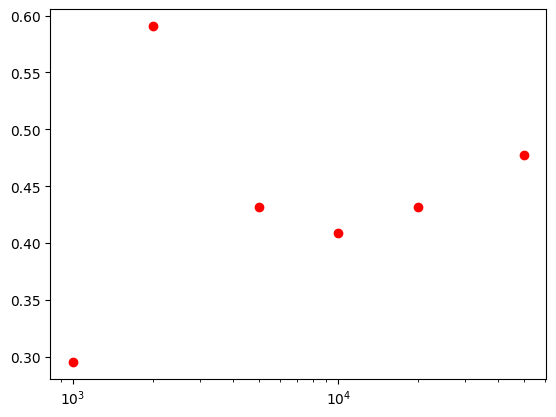

In [14]:
for i in range(len(scores)):
    plt.semilogx(parameters[i][2], scores[i], 'ro')

In [5]:
hots.plotlayers();


KeyboardInterrupt



In [ ]:
name = 'homeohots'
homeo = True
timestr = '2023-01-04'

R_first = [4]
N_layers = [2]
n_first = [16]
tau_first = [1.5e3]

scores, parameters = [], []

for lay in N_layers:
    for R in R_first:
        for tau in tau_first:
            for N_neuron in n_first:
                Rz = [R*2**Nl for Nl in range(lay)]
                N_neuronz = [64,32]#[N_neuron*2**Nl for Nl in range(lay)]
                N_pola = N_neuronz.copy()
                N_pola.insert(0,2)
                tauz = [tau*N_pola[Nl] for Nl in range(lay)]
                print(f'For tau equal: {tau}')
                
                hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)
                initial_name = hots.name
                filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
                path = record_path+'networks/'+hots.name+'.pkl'
                if not os.path.exists(path):
                    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold, device = 'cpu')
                #hots.plotlayers()
                
                hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=True, verbose=False)
                hots.coding(testloader, testset.ordering, testset.classes, filtering_threshold = filtering_threshold, training=False, verbose=False)
                
                jitter = (None, None)

                train_path = f'{record_path}output/train/{hots.name}_{num_sample_train}_{jitter}/'
                test_path = f'{record_path}output/test/{hots.name}_{num_sample_test}_{jitter}/'

                testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, transform=type_transform, dtype=trainset.dtype)
                trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, transform=type_transform, dtype=trainset.dtype)
                print(len(testset_output),len(trainset_output))
                
                score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1]) 
                
                scores.append(score)
                print(scores)
                
                parameters.append([lay, R, tau, N_neuron])

In [ ]:
kernels = classif_layer.linear.weight.data.cpu().numpy()
fig, ax = plt.subplots(N_output_neurons, kernels.shape[0], figsize=(30, 90))
for n in range(kernels.shape[0]):’z
    kernel = kernels[n].reshape(trainset.sensor_size[0],trainset.sensor_size[1], N_output_neurons)
    for p in range(N_output_neurons):
        ax[p, n].imshow(kernel[:,:,p])

In [ ]:
import tonic, torch, os
from hots.network import network
from hots.utils import apply_jitter, get_loader, get_sliced_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
kfold_test = None
kfold_clust = 10
ts_batch_size = 1000

dataset_name = 'gesture'
slicing_time_window = 1e6

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=type_transform)
loader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_clust)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_test)
num_sample_train = len(trainloader)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=True, kfold=kfold_test)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

name = 'homeohots'
homeo = True
timestr = '2022-04-22'

Rz = [4, 8]
N_neuronz = [16, 32]
tauz = [5e4*2, 5e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

#initial_name = hots.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
    
jitter = (None, None)
num_workers = 0
learning_rate = 0.0001
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 11#2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla_list = [1e5, 5e5, 1e6, 5e6, 1e7, 5e7, 1e8]

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

print(hots.name)

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)
hots.coding(testloader, testset.ordering, testset.classes, training=False, verbose=False)

drop_proba = .9
if drop_proba:
    drop_transform = tonic.transforms.DropEvent(p = drop_proba)
    full_drop_transform = tonic.transforms.Compose([drop_transform, type_transform])
else: full_drop_transform = type_transform

kfold_mlr = 10

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=full_drop_transform)
trainoutputloader = get_loader(trainset_output, kfold = kfold_mlr)
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output, kfold = kfold_mlr)

score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])

print(score, score_nohomeo)

for tau_cla in tau_cla_list:

    model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}_{drop_proba}.pkl'
    results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}_{drop_proba}.pkl'
    print(f'Number of samples in the trainset set: {len(trainoutputloader)}')
    
    print(len(trainoutputloader))
    
    classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), ts_batch_size = ts_batch_size)
    likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testoutputloader,results_path,ts_size,testset_output.ordering,  ts_batch_size = ts_batch_size)
    meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)#, figure_name = 'nmnist_online.pdf')
    print(f'For tau = {tau_cla} last accuracy: {lastac*100}% - mean accuracy: {meanac*100}%')
